# Segmentation map으로 도로 이미지 만들기
Pix2Pix  
[cityscapes.zip](https://d3s0tskafalll9.cloudfront.net/media/documents/cityscapes.zip)

1. 데이터에 한 가지 이상의 **augmentation 방법을 적용**하여 학습합니다.
2. 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 **U-Net Generator를 사용**합니다.
3. 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운받았던 “val” 폴더 내 이미지를 사용합니다.
4. 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 **스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화**합니다.
5. 모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 **중간 손실 값에 대한 로그**를 남깁니다. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.


## 1. 데이터 준비

In [ ]:
import os

# 데이터 불러오기
data_path = os.getenv('HOME')+'/aiffel/conditional_generation/data/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


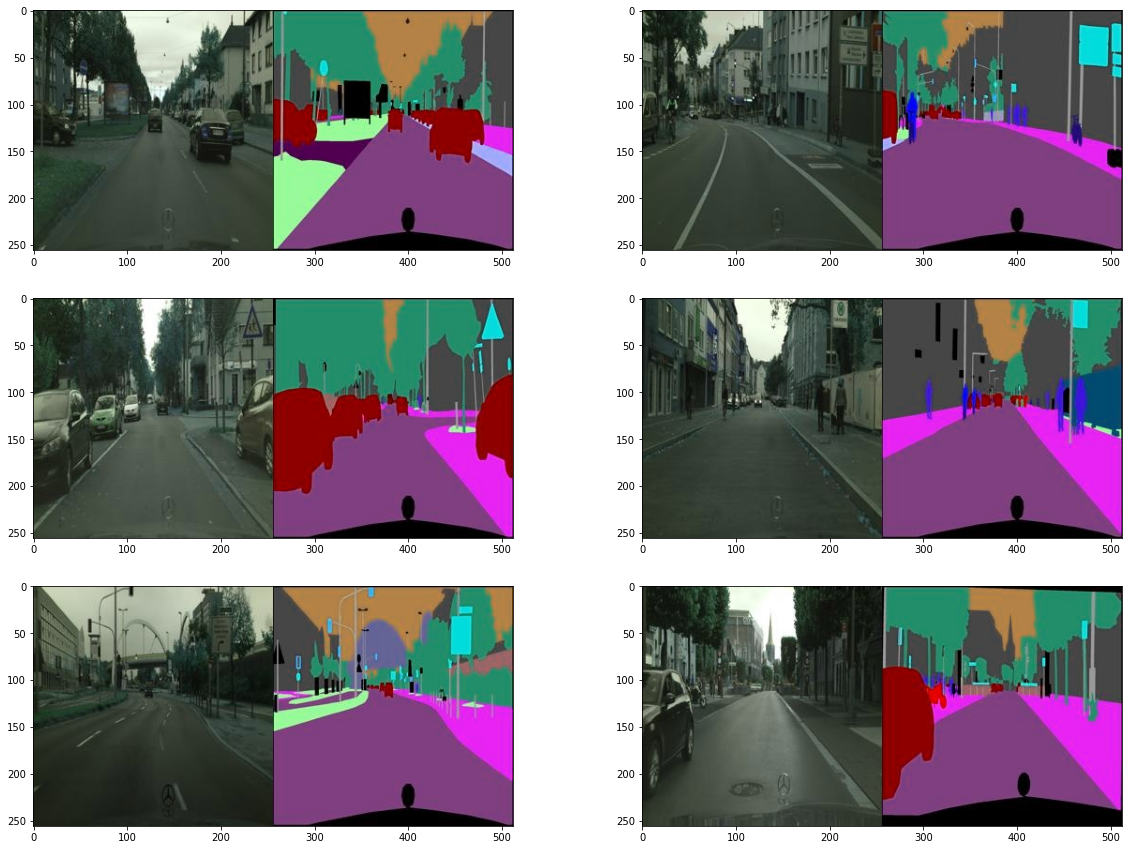

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 불러온 데이터 구경
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [ ]:
# 이미지 나누기
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


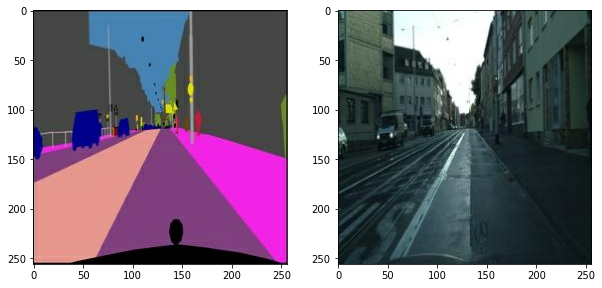

In [ ]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, w:, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, :w, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

## 2. augmentation 적용

In [ ]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


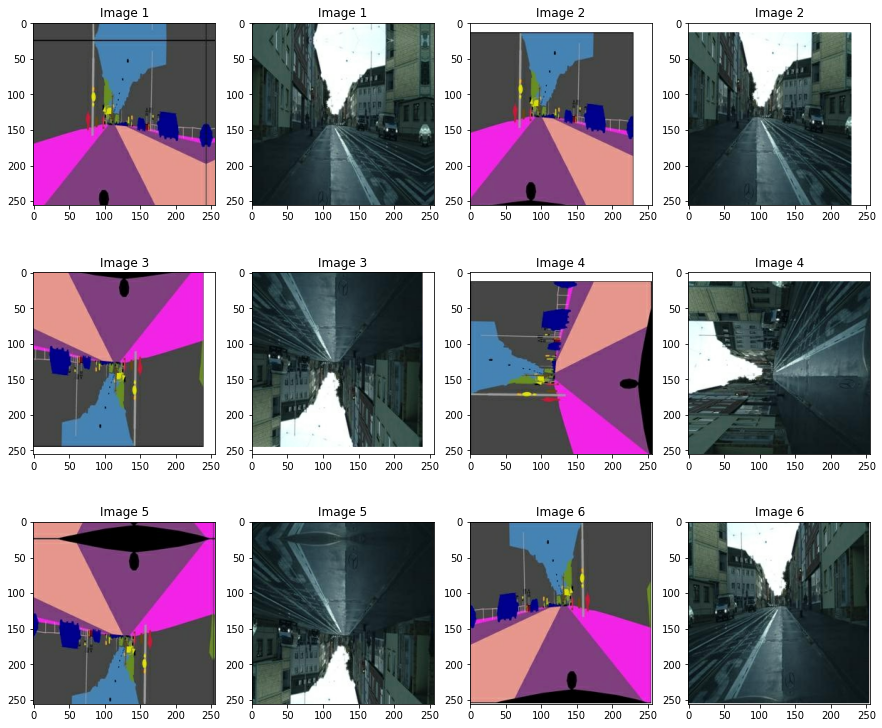

In [ ]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

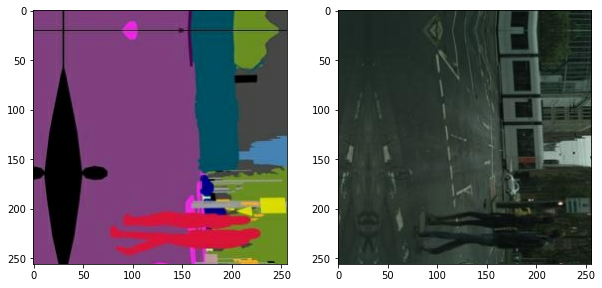

In [ ]:
# 하나만 시각화 해보기 

from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

## 3. U-Net Generator

In [ ]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


In [ ]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [ ]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

In [ ]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


In [ ]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_15 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [ ]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [ ]:
Discriminator().get_summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

## 4. 모델 학습 후, 학습된 Generator를 이용해 테스트
테스트 데이터는 다운받았던 "val" 폴더 내 이미지를 사용

In [ ]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


In [ ]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [ ]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


In [ ]:
EPOCHS = 100 

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.8723                     
L1_loss:0.3249                     
Discriminator_loss:1.3885

EPOCH[1] - STEP[20]                     
Generator_loss:0.9773                     
L1_loss:0.2894                     
Discriminator_loss:1.2522

EPOCH[1] - STEP[30]                     
Generator_loss:0.8627                     
L1_loss:0.2268                     
Discriminator_loss:1.3382

EPOCH[1] - STEP[40]                     
Generator_loss:0.8659                     
L1_loss:0.1892                     
Discriminator_loss:1.4383

EPOCH[1] - STEP[50]                     
Generator_loss:1.0666                     
L1_loss:0.2027                     
Discriminator_loss:1.0934

EPOCH[1] - STEP[60]                     
Generator_loss:1.1208                     
L1_loss:0.2405                     
Discriminator_loss:1.0422

EPOCH[1] - STEP[70]                     
Generator_loss:0.9134                     
L1_loss:0.1838                    

EPOCH[3] - STEP[70]                     
Generator_loss:1.9769                     
L1_loss:0.1601                     
Discriminator_loss:0.4857

EPOCH[3] - STEP[80]                     
Generator_loss:1.3985                     
L1_loss:0.2139                     
Discriminator_loss:0.8857

EPOCH[3] - STEP[90]                     
Generator_loss:1.4455                     
L1_loss:0.1838                     
Discriminator_loss:0.6565

EPOCH[3] - STEP[100]                     
Generator_loss:0.5103                     
L1_loss:0.1906                     
Discriminator_loss:1.3101

EPOCH[3] - STEP[110]                     
Generator_loss:1.5203                     
L1_loss:0.1957                     
Discriminator_loss:0.9764

EPOCH[3] - STEP[120]                     
Generator_loss:1.9014                     
L1_loss:0.1780                     
Discriminator_loss:0.4723

EPOCH[3] - STEP[130]                     
Generator_loss:1.7335                     
L1_loss:0.1550                

EPOCH[5] - STEP[130]                     
Generator_loss:2.8956                     
L1_loss:0.1827                     
Discriminator_loss:1.0124

EPOCH[5] - STEP[140]                     
Generator_loss:1.1072                     
L1_loss:0.1831                     
Discriminator_loss:0.8800

EPOCH[5] - STEP[150]                     
Generator_loss:1.8956                     
L1_loss:0.1894                     
Discriminator_loss:1.2917

EPOCH[5] - STEP[160]                     
Generator_loss:0.5779                     
L1_loss:0.1924                     
Discriminator_loss:1.1810

EPOCH[5] - STEP[170]                     
Generator_loss:1.1046                     
L1_loss:0.1491                     
Discriminator_loss:2.0044

EPOCH[5] - STEP[180]                     
Generator_loss:1.7202                     
L1_loss:0.1906                     
Discriminator_loss:0.4633

EPOCH[5] - STEP[190]                     
Generator_loss:1.9091                     
L1_loss:0.2309             

EPOCH[7] - STEP[190]                     
Generator_loss:1.8766                     
L1_loss:0.1504                     
Discriminator_loss:1.4147

EPOCH[7] - STEP[200]                     
Generator_loss:0.9313                     
L1_loss:0.1959                     
Discriminator_loss:0.8657

EPOCH[7] - STEP[210]                     
Generator_loss:2.4621                     
L1_loss:0.1678                     
Discriminator_loss:0.6152

EPOCH[7] - STEP[220]                     
Generator_loss:0.3566                     
L1_loss:0.1885                     
Discriminator_loss:2.6113

EPOCH[7] - STEP[230]                     
Generator_loss:0.3706                     
L1_loss:0.1756                     
Discriminator_loss:1.9633

EPOCH[7] - STEP[240]                     
Generator_loss:1.0375                     
L1_loss:0.2200                     
Discriminator_loss:0.6176

EPOCH[7] - STEP[250]                     
Generator_loss:2.1595                     
L1_loss:0.2016             

EPOCH[9] - STEP[250]                     
Generator_loss:3.1903                     
L1_loss:0.1790                     
Discriminator_loss:1.3416

EPOCH[10] - STEP[10]                     
Generator_loss:1.4626                     
L1_loss:0.1621                     
Discriminator_loss:0.5511

EPOCH[10] - STEP[20]                     
Generator_loss:2.5996                     
L1_loss:0.1838                     
Discriminator_loss:0.3806

EPOCH[10] - STEP[30]                     
Generator_loss:0.9542                     
L1_loss:0.1588                     
Discriminator_loss:0.8036

EPOCH[10] - STEP[40]                     
Generator_loss:2.2091                     
L1_loss:0.1578                     
Discriminator_loss:0.4326

EPOCH[10] - STEP[50]                     
Generator_loss:2.0293                     
L1_loss:0.1930                     
Discriminator_loss:0.9350

EPOCH[10] - STEP[60]                     
Generator_loss:0.7665                     
L1_loss:0.1802             

EPOCH[12] - STEP[60]                     
Generator_loss:0.9569                     
L1_loss:0.1940                     
Discriminator_loss:0.6260

EPOCH[12] - STEP[70]                     
Generator_loss:0.2876                     
L1_loss:0.2075                     
Discriminator_loss:1.6125

EPOCH[12] - STEP[80]                     
Generator_loss:1.8520                     
L1_loss:0.1642                     
Discriminator_loss:0.8445

EPOCH[12] - STEP[90]                     
Generator_loss:0.5282                     
L1_loss:0.1732                     
Discriminator_loss:1.0813

EPOCH[12] - STEP[100]                     
Generator_loss:0.5067                     
L1_loss:0.1757                     
Discriminator_loss:1.6753

EPOCH[12] - STEP[110]                     
Generator_loss:0.6132                     
L1_loss:0.2328                     
Discriminator_loss:1.0233

EPOCH[12] - STEP[120]                     
Generator_loss:1.1323                     
L1_loss:0.1875          

EPOCH[14] - STEP[120]                     
Generator_loss:1.6251                     
L1_loss:0.1678                     
Discriminator_loss:1.0676

EPOCH[14] - STEP[130]                     
Generator_loss:1.1563                     
L1_loss:0.1588                     
Discriminator_loss:0.7893

EPOCH[14] - STEP[140]                     
Generator_loss:1.2087                     
L1_loss:0.1514                     
Discriminator_loss:1.4083

EPOCH[14] - STEP[150]                     
Generator_loss:0.6983                     
L1_loss:0.1758                     
Discriminator_loss:1.0096

EPOCH[14] - STEP[160]                     
Generator_loss:1.1044                     
L1_loss:0.1752                     
Discriminator_loss:1.1154

EPOCH[14] - STEP[170]                     
Generator_loss:2.0484                     
L1_loss:0.2099                     
Discriminator_loss:0.2308

EPOCH[14] - STEP[180]                     
Generator_loss:2.1348                     
L1_loss:0.2003      

EPOCH[16] - STEP[180]                     
Generator_loss:2.0026                     
L1_loss:0.2204                     
Discriminator_loss:0.2409

EPOCH[16] - STEP[190]                     
Generator_loss:2.5114                     
L1_loss:0.1557                     
Discriminator_loss:1.4040

EPOCH[16] - STEP[200]                     
Generator_loss:2.1778                     
L1_loss:0.1858                     
Discriminator_loss:0.2345

EPOCH[16] - STEP[210]                     
Generator_loss:1.3845                     
L1_loss:0.1782                     
Discriminator_loss:0.4591

EPOCH[16] - STEP[220]                     
Generator_loss:1.2235                     
L1_loss:0.1892                     
Discriminator_loss:0.4224

EPOCH[16] - STEP[230]                     
Generator_loss:1.5348                     
L1_loss:0.1991                     
Discriminator_loss:0.3319

EPOCH[16] - STEP[240]                     
Generator_loss:1.0570                     
L1_loss:0.1636      

EPOCH[18] - STEP[240]                     
Generator_loss:0.9066                     
L1_loss:0.1479                     
Discriminator_loss:1.1031

EPOCH[18] - STEP[250]                     
Generator_loss:0.6486                     
L1_loss:0.2006                     
Discriminator_loss:1.0975

EPOCH[19] - STEP[10]                     
Generator_loss:1.7006                     
L1_loss:0.1543                     
Discriminator_loss:0.8915

EPOCH[19] - STEP[20]                     
Generator_loss:1.6236                     
L1_loss:0.1496                     
Discriminator_loss:0.7695

EPOCH[19] - STEP[30]                     
Generator_loss:1.0335                     
L1_loss:0.1669                     
Discriminator_loss:0.6720

EPOCH[19] - STEP[40]                     
Generator_loss:0.4417                     
L1_loss:0.1585                     
Discriminator_loss:1.3332

EPOCH[19] - STEP[50]                     
Generator_loss:0.5997                     
L1_loss:0.1593           

EPOCH[21] - STEP[50]                     
Generator_loss:1.3458                     
L1_loss:0.1760                     
Discriminator_loss:0.8557

EPOCH[21] - STEP[60]                     
Generator_loss:1.5242                     
L1_loss:0.1844                     
Discriminator_loss:0.3964

EPOCH[21] - STEP[70]                     
Generator_loss:1.2355                     
L1_loss:0.1714                     
Discriminator_loss:0.5705

EPOCH[21] - STEP[80]                     
Generator_loss:0.8142                     
L1_loss:0.1899                     
Discriminator_loss:0.7482

EPOCH[21] - STEP[90]                     
Generator_loss:1.4706                     
L1_loss:0.1785                     
Discriminator_loss:0.5460

EPOCH[21] - STEP[100]                     
Generator_loss:1.1431                     
L1_loss:0.1615                     
Discriminator_loss:0.9501

EPOCH[21] - STEP[110]                     
Generator_loss:1.8748                     
L1_loss:0.2168           

EPOCH[23] - STEP[110]                     
Generator_loss:1.3403                     
L1_loss:0.1741                     
Discriminator_loss:0.9474

EPOCH[23] - STEP[120]                     
Generator_loss:1.3691                     
L1_loss:0.1861                     
Discriminator_loss:0.4044

EPOCH[23] - STEP[130]                     
Generator_loss:1.6706                     
L1_loss:0.1844                     
Discriminator_loss:0.7032

EPOCH[23] - STEP[140]                     
Generator_loss:2.4696                     
L1_loss:0.1773                     
Discriminator_loss:0.6054

EPOCH[23] - STEP[150]                     
Generator_loss:1.5653                     
L1_loss:0.1632                     
Discriminator_loss:0.7460

EPOCH[23] - STEP[160]                     
Generator_loss:1.3102                     
L1_loss:0.1679                     
Discriminator_loss:0.8789

EPOCH[23] - STEP[170]                     
Generator_loss:0.3843                     
L1_loss:0.1712      

EPOCH[25] - STEP[170]                     
Generator_loss:1.1938                     
L1_loss:0.1500                     
Discriminator_loss:1.4691

EPOCH[25] - STEP[180]                     
Generator_loss:2.3660                     
L1_loss:0.1797                     
Discriminator_loss:0.4103

EPOCH[25] - STEP[190]                     
Generator_loss:3.0153                     
L1_loss:0.1686                     
Discriminator_loss:3.3264

EPOCH[25] - STEP[200]                     
Generator_loss:1.1469                     
L1_loss:0.1299                     
Discriminator_loss:1.1560

EPOCH[25] - STEP[210]                     
Generator_loss:1.1553                     
L1_loss:0.1694                     
Discriminator_loss:0.5269

EPOCH[25] - STEP[220]                     
Generator_loss:1.5534                     
L1_loss:0.1614                     
Discriminator_loss:1.6661

EPOCH[25] - STEP[230]                     
Generator_loss:2.2876                     
L1_loss:0.1787      

EPOCH[27] - STEP[230]                     
Generator_loss:1.2915                     
L1_loss:0.1661                     
Discriminator_loss:1.5389

EPOCH[27] - STEP[240]                     
Generator_loss:1.3313                     
L1_loss:0.1563                     
Discriminator_loss:0.5044

EPOCH[27] - STEP[250]                     
Generator_loss:2.1834                     
L1_loss:0.1788                     
Discriminator_loss:0.2199

EPOCH[28] - STEP[10]                     
Generator_loss:1.4685                     
L1_loss:0.1676                     
Discriminator_loss:0.5699

EPOCH[28] - STEP[20]                     
Generator_loss:1.6495                     
L1_loss:0.1755                     
Discriminator_loss:0.5704

EPOCH[28] - STEP[30]                     
Generator_loss:2.0261                     
L1_loss:0.1801                     
Discriminator_loss:1.8801

EPOCH[28] - STEP[40]                     
Generator_loss:1.3976                     
L1_loss:0.1513          

EPOCH[30] - STEP[40]                     
Generator_loss:0.6536                     
L1_loss:0.1508                     
Discriminator_loss:1.1093

EPOCH[30] - STEP[50]                     
Generator_loss:1.5805                     
L1_loss:0.1669                     
Discriminator_loss:0.6635

EPOCH[30] - STEP[60]                     
Generator_loss:1.7522                     
L1_loss:0.1815                     
Discriminator_loss:1.0351

EPOCH[30] - STEP[70]                     
Generator_loss:1.4350                     
L1_loss:0.1892                     
Discriminator_loss:0.8697

EPOCH[30] - STEP[80]                     
Generator_loss:1.5462                     
L1_loss:0.1966                     
Discriminator_loss:0.2977

EPOCH[30] - STEP[90]                     
Generator_loss:0.8444                     
L1_loss:0.1754                     
Discriminator_loss:0.6969

EPOCH[30] - STEP[100]                     
Generator_loss:1.2926                     
L1_loss:0.1748            

EPOCH[32] - STEP[100]                     
Generator_loss:1.0295                     
L1_loss:0.1804                     
Discriminator_loss:0.7985

EPOCH[32] - STEP[110]                     
Generator_loss:1.7168                     
L1_loss:0.1994                     
Discriminator_loss:0.2336

EPOCH[32] - STEP[120]                     
Generator_loss:0.2247                     
L1_loss:0.1791                     
Discriminator_loss:1.8816

EPOCH[32] - STEP[130]                     
Generator_loss:2.0048                     
L1_loss:0.1606                     
Discriminator_loss:0.6520

EPOCH[32] - STEP[140]                     
Generator_loss:1.8863                     
L1_loss:0.1489                     
Discriminator_loss:1.1314

EPOCH[32] - STEP[150]                     
Generator_loss:1.8044                     
L1_loss:0.1798                     
Discriminator_loss:0.3843

EPOCH[32] - STEP[160]                     
Generator_loss:1.1982                     
L1_loss:0.1893      

EPOCH[34] - STEP[160]                     
Generator_loss:1.7188                     
L1_loss:0.2032                     
Discriminator_loss:0.9199

EPOCH[34] - STEP[170]                     
Generator_loss:3.1794                     
L1_loss:0.2022                     
Discriminator_loss:0.3349

EPOCH[34] - STEP[180]                     
Generator_loss:2.1445                     
L1_loss:0.1994                     
Discriminator_loss:0.2994

EPOCH[34] - STEP[190]                     
Generator_loss:2.7156                     
L1_loss:0.1447                     
Discriminator_loss:2.2775

EPOCH[34] - STEP[200]                     
Generator_loss:2.2430                     
L1_loss:0.1452                     
Discriminator_loss:1.3083

EPOCH[34] - STEP[210]                     
Generator_loss:1.0010                     
L1_loss:0.1642                     
Discriminator_loss:1.7699

EPOCH[34] - STEP[220]                     
Generator_loss:0.2898                     
L1_loss:0.1970      

EPOCH[36] - STEP[220]                     
Generator_loss:2.2792                     
L1_loss:0.1494                     
Discriminator_loss:1.1172

EPOCH[36] - STEP[230]                     
Generator_loss:1.4260                     
L1_loss:0.1657                     
Discriminator_loss:0.9955

EPOCH[36] - STEP[240]                     
Generator_loss:0.2959                     
L1_loss:0.1773                     
Discriminator_loss:1.7028

EPOCH[36] - STEP[250]                     
Generator_loss:1.4421                     
L1_loss:0.1495                     
Discriminator_loss:0.4511

EPOCH[37] - STEP[10]                     
Generator_loss:2.4877                     
L1_loss:0.1798                     
Discriminator_loss:0.4218

EPOCH[37] - STEP[20]                     
Generator_loss:0.9208                     
L1_loss:0.1740                     
Discriminator_loss:0.5813

EPOCH[37] - STEP[30]                     
Generator_loss:2.6882                     
L1_loss:0.1685         

EPOCH[39] - STEP[30]                     
Generator_loss:2.4787                     
L1_loss:0.1397                     
Discriminator_loss:1.4670

EPOCH[39] - STEP[40]                     
Generator_loss:1.2773                     
L1_loss:0.1813                     
Discriminator_loss:0.6736

EPOCH[39] - STEP[50]                     
Generator_loss:0.4212                     
L1_loss:0.1689                     
Discriminator_loss:1.5445

EPOCH[39] - STEP[60]                     
Generator_loss:2.3210                     
L1_loss:0.1910                     
Discriminator_loss:0.7190

EPOCH[39] - STEP[70]                     
Generator_loss:1.7625                     
L1_loss:0.2253                     
Discriminator_loss:0.2191

EPOCH[39] - STEP[80]                     
Generator_loss:2.0639                     
L1_loss:0.2213                     
Discriminator_loss:0.2207

EPOCH[39] - STEP[90]                     
Generator_loss:0.9407                     
L1_loss:0.1934             

EPOCH[41] - STEP[90]                     
Generator_loss:2.2129                     
L1_loss:0.1714                     
Discriminator_loss:0.5922

EPOCH[41] - STEP[100]                     
Generator_loss:0.5344                     
L1_loss:0.2057                     
Discriminator_loss:1.2215

EPOCH[41] - STEP[110]                     
Generator_loss:0.5815                     
L1_loss:0.1570                     
Discriminator_loss:1.7691

EPOCH[41] - STEP[120]                     
Generator_loss:1.6521                     
L1_loss:0.1531                     
Discriminator_loss:2.8578

EPOCH[41] - STEP[130]                     
Generator_loss:1.6837                     
L1_loss:0.1710                     
Discriminator_loss:0.5114

EPOCH[41] - STEP[140]                     
Generator_loss:1.1588                     
L1_loss:0.2134                     
Discriminator_loss:0.5432

EPOCH[41] - STEP[150]                     
Generator_loss:1.7303                     
L1_loss:0.1469       

EPOCH[43] - STEP[150]                     
Generator_loss:2.0411                     
L1_loss:0.1650                     
Discriminator_loss:0.3471

EPOCH[43] - STEP[160]                     
Generator_loss:1.5235                     
L1_loss:0.1893                     
Discriminator_loss:0.6349

EPOCH[43] - STEP[170]                     
Generator_loss:0.4960                     
L1_loss:0.1546                     
Discriminator_loss:1.2258

EPOCH[43] - STEP[180]                     
Generator_loss:1.2850                     
L1_loss:0.1647                     
Discriminator_loss:0.9525

EPOCH[43] - STEP[190]                     
Generator_loss:0.8223                     
L1_loss:0.1808                     
Discriminator_loss:1.0737

EPOCH[43] - STEP[200]                     
Generator_loss:2.2153                     
L1_loss:0.1633                     
Discriminator_loss:1.5487

EPOCH[43] - STEP[210]                     
Generator_loss:1.8258                     
L1_loss:0.1825      

EPOCH[45] - STEP[210]                     
Generator_loss:0.8356                     
L1_loss:0.1593                     
Discriminator_loss:1.4506

EPOCH[45] - STEP[220]                     
Generator_loss:3.1467                     
L1_loss:0.1906                     
Discriminator_loss:1.0743

EPOCH[45] - STEP[230]                     
Generator_loss:1.9691                     
L1_loss:0.1560                     
Discriminator_loss:1.5470

EPOCH[45] - STEP[240]                     
Generator_loss:1.0142                     
L1_loss:0.1724                     
Discriminator_loss:0.7165

EPOCH[45] - STEP[250]                     
Generator_loss:1.4751                     
L1_loss:0.1592                     
Discriminator_loss:1.1419

EPOCH[46] - STEP[10]                     
Generator_loss:1.3970                     
L1_loss:0.1461                     
Discriminator_loss:1.2327

EPOCH[46] - STEP[20]                     
Generator_loss:1.2274                     
L1_loss:0.1796        

EPOCH[48] - STEP[20]                     
Generator_loss:2.5417                     
L1_loss:0.1753                     
Discriminator_loss:0.8198

EPOCH[48] - STEP[30]                     
Generator_loss:1.3657                     
L1_loss:0.1628                     
Discriminator_loss:1.8348

EPOCH[48] - STEP[40]                     
Generator_loss:1.5959                     
L1_loss:0.1689                     
Discriminator_loss:0.9332

EPOCH[48] - STEP[50]                     
Generator_loss:1.0672                     
L1_loss:0.1378                     
Discriminator_loss:1.8940

EPOCH[48] - STEP[60]                     
Generator_loss:1.1090                     
L1_loss:0.1966                     
Discriminator_loss:0.5417

EPOCH[48] - STEP[70]                     
Generator_loss:1.4741                     
L1_loss:0.1602                     
Discriminator_loss:0.6832

EPOCH[48] - STEP[80]                     
Generator_loss:2.3247                     
L1_loss:0.1698             

EPOCH[50] - STEP[80]                     
Generator_loss:0.9382                     
L1_loss:0.1876                     
Discriminator_loss:0.7757

EPOCH[50] - STEP[90]                     
Generator_loss:2.4798                     
L1_loss:0.1965                     
Discriminator_loss:0.2604

EPOCH[50] - STEP[100]                     
Generator_loss:1.5691                     
L1_loss:0.2032                     
Discriminator_loss:0.2718

EPOCH[50] - STEP[110]                     
Generator_loss:2.4192                     
L1_loss:0.1833                     
Discriminator_loss:0.8324

EPOCH[50] - STEP[120]                     
Generator_loss:1.7722                     
L1_loss:0.1805                     
Discriminator_loss:1.1423

EPOCH[50] - STEP[130]                     
Generator_loss:1.0344                     
L1_loss:0.1843                     
Discriminator_loss:0.5742

EPOCH[50] - STEP[140]                     
Generator_loss:1.9183                     
L1_loss:0.2024        

EPOCH[52] - STEP[140]                     
Generator_loss:2.0025                     
L1_loss:0.1754                     
Discriminator_loss:1.7995

EPOCH[52] - STEP[150]                     
Generator_loss:1.9570                     
L1_loss:0.1963                     
Discriminator_loss:0.3782

EPOCH[52] - STEP[160]                     
Generator_loss:1.9108                     
L1_loss:0.1810                     
Discriminator_loss:0.6050

EPOCH[52] - STEP[170]                     
Generator_loss:1.5171                     
L1_loss:0.1529                     
Discriminator_loss:0.8300

EPOCH[52] - STEP[180]                     
Generator_loss:1.6767                     
L1_loss:0.1715                     
Discriminator_loss:1.6043

EPOCH[52] - STEP[190]                     
Generator_loss:2.5276                     
L1_loss:0.1707                     
Discriminator_loss:0.5460

EPOCH[52] - STEP[200]                     
Generator_loss:1.8361                     
L1_loss:0.1830      

EPOCH[54] - STEP[200]                     
Generator_loss:2.4453                     
L1_loss:0.1593                     
Discriminator_loss:0.4862

EPOCH[54] - STEP[210]                     
Generator_loss:1.8277                     
L1_loss:0.1659                     
Discriminator_loss:1.0618

EPOCH[54] - STEP[220]                     
Generator_loss:1.1809                     
L1_loss:0.1733                     
Discriminator_loss:0.9117

EPOCH[54] - STEP[230]                     
Generator_loss:1.3194                     
L1_loss:0.1863                     
Discriminator_loss:0.5048

EPOCH[54] - STEP[240]                     
Generator_loss:1.3775                     
L1_loss:0.1525                     
Discriminator_loss:0.6529

EPOCH[54] - STEP[250]                     
Generator_loss:1.4342                     
L1_loss:0.1697                     
Discriminator_loss:1.6723

EPOCH[55] - STEP[10]                     
Generator_loss:1.0493                     
L1_loss:0.2319       

EPOCH[57] - STEP[10]                     
Generator_loss:0.8299                     
L1_loss:0.1489                     
Discriminator_loss:1.0080

EPOCH[57] - STEP[20]                     
Generator_loss:1.1730                     
L1_loss:0.1666                     
Discriminator_loss:1.1974

EPOCH[57] - STEP[30]                     
Generator_loss:1.1953                     
L1_loss:0.1829                     
Discriminator_loss:2.2044

EPOCH[57] - STEP[40]                     
Generator_loss:1.2587                     
L1_loss:0.1513                     
Discriminator_loss:2.1259

EPOCH[57] - STEP[50]                     
Generator_loss:0.9351                     
L1_loss:0.1678                     
Discriminator_loss:1.1122

EPOCH[57] - STEP[60]                     
Generator_loss:2.4476                     
L1_loss:0.1410                     
Discriminator_loss:1.4992

EPOCH[57] - STEP[70]                     
Generator_loss:1.7505                     
L1_loss:0.1750             

EPOCH[59] - STEP[70]                     
Generator_loss:1.2788                     
L1_loss:0.1737                     
Discriminator_loss:0.4567

EPOCH[59] - STEP[80]                     
Generator_loss:0.9590                     
L1_loss:0.1573                     
Discriminator_loss:0.9107

EPOCH[59] - STEP[90]                     
Generator_loss:1.8065                     
L1_loss:0.1719                     
Discriminator_loss:0.4288

EPOCH[59] - STEP[100]                     
Generator_loss:1.3682                     
L1_loss:0.1753                     
Discriminator_loss:0.8010

EPOCH[59] - STEP[110]                     
Generator_loss:0.9935                     
L1_loss:0.1720                     
Discriminator_loss:0.7437

EPOCH[59] - STEP[120]                     
Generator_loss:1.4883                     
L1_loss:0.1810                     
Discriminator_loss:0.6485

EPOCH[59] - STEP[130]                     
Generator_loss:1.7092                     
L1_loss:0.1657         

EPOCH[61] - STEP[130]                     
Generator_loss:1.2746                     
L1_loss:0.1635                     
Discriminator_loss:1.0697

EPOCH[61] - STEP[140]                     
Generator_loss:2.0678                     
L1_loss:0.1776                     
Discriminator_loss:0.2425

EPOCH[61] - STEP[150]                     
Generator_loss:1.3978                     
L1_loss:0.1635                     
Discriminator_loss:0.8154

EPOCH[61] - STEP[160]                     
Generator_loss:0.8365                     
L1_loss:0.1683                     
Discriminator_loss:0.7961

EPOCH[61] - STEP[170]                     
Generator_loss:0.8290                     
L1_loss:0.1743                     
Discriminator_loss:1.1576

EPOCH[61] - STEP[180]                     
Generator_loss:1.6609                     
L1_loss:0.1526                     
Discriminator_loss:1.4271

EPOCH[61] - STEP[190]                     
Generator_loss:2.0703                     
L1_loss:0.1950      

EPOCH[63] - STEP[190]                     
Generator_loss:1.9898                     
L1_loss:0.1843                     
Discriminator_loss:0.4209

EPOCH[63] - STEP[200]                     
Generator_loss:0.5788                     
L1_loss:0.1726                     
Discriminator_loss:1.0887

EPOCH[63] - STEP[210]                     
Generator_loss:1.3968                     
L1_loss:0.1849                     
Discriminator_loss:0.5114

EPOCH[63] - STEP[220]                     
Generator_loss:1.1977                     
L1_loss:0.1570                     
Discriminator_loss:0.6021

EPOCH[63] - STEP[230]                     
Generator_loss:1.7180                     
L1_loss:0.1654                     
Discriminator_loss:0.7266

EPOCH[63] - STEP[240]                     
Generator_loss:1.5895                     
L1_loss:0.1445                     
Discriminator_loss:0.9018

EPOCH[63] - STEP[250]                     
Generator_loss:1.2808                     
L1_loss:0.1718      

EPOCH[65] - STEP[250]                     
Generator_loss:1.8376                     
L1_loss:0.1870                     
Discriminator_loss:0.6093

EPOCH[66] - STEP[10]                     
Generator_loss:2.0781                     
L1_loss:0.1959                     
Discriminator_loss:0.3458

EPOCH[66] - STEP[20]                     
Generator_loss:1.2689                     
L1_loss:0.1513                     
Discriminator_loss:0.9865

EPOCH[66] - STEP[30]                     
Generator_loss:2.2579                     
L1_loss:0.1650                     
Discriminator_loss:1.0718

EPOCH[66] - STEP[40]                     
Generator_loss:2.4069                     
L1_loss:0.1471                     
Discriminator_loss:3.0768

EPOCH[66] - STEP[50]                     
Generator_loss:1.0110                     
L1_loss:0.1534                     
Discriminator_loss:1.6886

EPOCH[66] - STEP[60]                     
Generator_loss:1.7293                     
L1_loss:0.1532            

EPOCH[68] - STEP[60]                     
Generator_loss:1.9293                     
L1_loss:0.1953                     
Discriminator_loss:0.2618

EPOCH[68] - STEP[70]                     
Generator_loss:0.8669                     
L1_loss:0.1884                     
Discriminator_loss:0.8591

EPOCH[68] - STEP[80]                     
Generator_loss:1.3675                     
L1_loss:0.1466                     
Discriminator_loss:0.6578

EPOCH[68] - STEP[90]                     
Generator_loss:2.3856                     
L1_loss:0.1558                     
Discriminator_loss:1.6432

EPOCH[68] - STEP[100]                     
Generator_loss:1.8415                     
L1_loss:0.1727                     
Discriminator_loss:0.8297

EPOCH[68] - STEP[110]                     
Generator_loss:0.6557                     
L1_loss:0.2218                     
Discriminator_loss:0.8776

EPOCH[68] - STEP[120]                     
Generator_loss:1.1057                     
L1_loss:0.1576          

EPOCH[70] - STEP[120]                     
Generator_loss:2.5926                     
L1_loss:0.1725                     
Discriminator_loss:3.1553

EPOCH[70] - STEP[130]                     
Generator_loss:0.8860                     
L1_loss:0.1596                     
Discriminator_loss:1.8732

EPOCH[70] - STEP[140]                     
Generator_loss:1.4146                     
L1_loss:0.1937                     
Discriminator_loss:0.3598

EPOCH[70] - STEP[150]                     
Generator_loss:2.1341                     
L1_loss:0.1769                     
Discriminator_loss:0.4564

EPOCH[70] - STEP[160]                     
Generator_loss:2.2476                     
L1_loss:0.1728                     
Discriminator_loss:0.7679

EPOCH[70] - STEP[170]                     
Generator_loss:1.5619                     
L1_loss:0.1556                     
Discriminator_loss:1.0445

EPOCH[70] - STEP[180]                     
Generator_loss:1.1905                     
L1_loss:0.1636      

EPOCH[72] - STEP[180]                     
Generator_loss:0.4666                     
L1_loss:0.1802                     
Discriminator_loss:1.3893

EPOCH[72] - STEP[190]                     
Generator_loss:0.9771                     
L1_loss:0.1386                     
Discriminator_loss:1.0113

EPOCH[72] - STEP[200]                     
Generator_loss:0.6742                     
L1_loss:0.1706                     
Discriminator_loss:1.0745

EPOCH[72] - STEP[210]                     
Generator_loss:1.4269                     
L1_loss:0.1908                     
Discriminator_loss:0.4253

EPOCH[72] - STEP[220]                     
Generator_loss:1.2924                     
L1_loss:0.1467                     
Discriminator_loss:1.2725

EPOCH[72] - STEP[230]                     
Generator_loss:2.1787                     
L1_loss:0.1827                     
Discriminator_loss:0.5632

EPOCH[72] - STEP[240]                     
Generator_loss:2.6545                     
L1_loss:0.1491      

EPOCH[74] - STEP[240]                     
Generator_loss:0.6657                     
L1_loss:0.1716                     
Discriminator_loss:0.9558

EPOCH[74] - STEP[250]                     
Generator_loss:2.2617                     
L1_loss:0.1792                     
Discriminator_loss:0.2930

EPOCH[75] - STEP[10]                     
Generator_loss:1.5298                     
L1_loss:0.1889                     
Discriminator_loss:0.3169

EPOCH[75] - STEP[20]                     
Generator_loss:0.4887                     
L1_loss:0.1535                     
Discriminator_loss:1.1768

EPOCH[75] - STEP[30]                     
Generator_loss:1.5527                     
L1_loss:0.1462                     
Discriminator_loss:1.5359

EPOCH[75] - STEP[40]                     
Generator_loss:1.7151                     
L1_loss:0.1705                     
Discriminator_loss:0.7810

EPOCH[75] - STEP[50]                     
Generator_loss:1.1753                     
L1_loss:0.1789           

EPOCH[77] - STEP[50]                     
Generator_loss:1.7665                     
L1_loss:0.1988                     
Discriminator_loss:0.3021

EPOCH[77] - STEP[60]                     
Generator_loss:0.6780                     
L1_loss:0.1781                     
Discriminator_loss:0.9580

EPOCH[77] - STEP[70]                     
Generator_loss:0.9594                     
L1_loss:0.1732                     
Discriminator_loss:0.7827

EPOCH[77] - STEP[80]                     
Generator_loss:1.1905                     
L1_loss:0.1518                     
Discriminator_loss:1.2617

EPOCH[77] - STEP[90]                     
Generator_loss:2.1266                     
L1_loss:0.1594                     
Discriminator_loss:0.3027

EPOCH[77] - STEP[100]                     
Generator_loss:1.8175                     
L1_loss:0.1740                     
Discriminator_loss:1.0463

EPOCH[77] - STEP[110]                     
Generator_loss:0.6075                     
L1_loss:0.1920           

EPOCH[79] - STEP[110]                     
Generator_loss:0.4174                     
L1_loss:0.2134                     
Discriminator_loss:1.2885

EPOCH[79] - STEP[120]                     
Generator_loss:1.1857                     
L1_loss:0.1743                     
Discriminator_loss:0.5396

EPOCH[79] - STEP[130]                     
Generator_loss:1.3169                     
L1_loss:0.1820                     
Discriminator_loss:0.4716

EPOCH[79] - STEP[140]                     
Generator_loss:1.2692                     
L1_loss:0.1807                     
Discriminator_loss:1.0073

EPOCH[79] - STEP[150]                     
Generator_loss:1.8184                     
L1_loss:0.1675                     
Discriminator_loss:0.3064

EPOCH[79] - STEP[160]                     
Generator_loss:0.7696                     
L1_loss:0.1889                     
Discriminator_loss:0.7456

EPOCH[79] - STEP[170]                     
Generator_loss:1.1223                     
L1_loss:0.1758      

EPOCH[81] - STEP[170]                     
Generator_loss:0.8357                     
L1_loss:0.2011                     
Discriminator_loss:0.6876

EPOCH[81] - STEP[180]                     
Generator_loss:1.4214                     
L1_loss:0.1916                     
Discriminator_loss:0.9303

EPOCH[81] - STEP[190]                     
Generator_loss:1.1187                     
L1_loss:0.1577                     
Discriminator_loss:1.9708

EPOCH[81] - STEP[200]                     
Generator_loss:0.7237                     
L1_loss:0.1577                     
Discriminator_loss:0.8379

EPOCH[81] - STEP[210]                     
Generator_loss:1.6277                     
L1_loss:0.2001                     
Discriminator_loss:0.4339

EPOCH[81] - STEP[220]                     
Generator_loss:1.1560                     
L1_loss:0.1753                     
Discriminator_loss:1.7612

EPOCH[81] - STEP[230]                     
Generator_loss:1.0669                     
L1_loss:0.2173      

EPOCH[83] - STEP[230]                     
Generator_loss:0.8258                     
L1_loss:0.1667                     
Discriminator_loss:0.7620

EPOCH[83] - STEP[240]                     
Generator_loss:0.7664                     
L1_loss:0.1763                     
Discriminator_loss:1.1580

EPOCH[83] - STEP[250]                     
Generator_loss:1.8403                     
L1_loss:0.1548                     
Discriminator_loss:0.9088

EPOCH[84] - STEP[10]                     
Generator_loss:1.1341                     
L1_loss:0.1791                     
Discriminator_loss:0.8225

EPOCH[84] - STEP[20]                     
Generator_loss:1.2061                     
L1_loss:0.1576                     
Discriminator_loss:0.9127

EPOCH[84] - STEP[30]                     
Generator_loss:1.3193                     
L1_loss:0.1516                     
Discriminator_loss:0.5286

EPOCH[84] - STEP[40]                     
Generator_loss:2.0902                     
L1_loss:0.1633          

EPOCH[86] - STEP[40]                     
Generator_loss:1.5899                     
L1_loss:0.1596                     
Discriminator_loss:0.8462

EPOCH[86] - STEP[50]                     
Generator_loss:1.4776                     
L1_loss:0.1650                     
Discriminator_loss:0.8709

EPOCH[86] - STEP[60]                     
Generator_loss:2.0436                     
L1_loss:0.1719                     
Discriminator_loss:1.0987

EPOCH[86] - STEP[70]                     
Generator_loss:1.3463                     
L1_loss:0.1548                     
Discriminator_loss:0.6090

EPOCH[86] - STEP[80]                     
Generator_loss:1.3499                     
L1_loss:0.1551                     
Discriminator_loss:0.7530

EPOCH[86] - STEP[90]                     
Generator_loss:1.7018                     
L1_loss:0.2363                     
Discriminator_loss:0.2329

EPOCH[86] - STEP[100]                     
Generator_loss:1.5150                     
L1_loss:0.1308            

EPOCH[88] - STEP[100]                     
Generator_loss:2.0168                     
L1_loss:0.1569                     
Discriminator_loss:2.0737

EPOCH[88] - STEP[110]                     
Generator_loss:2.1615                     
L1_loss:0.1929                     
Discriminator_loss:0.5313

EPOCH[88] - STEP[120]                     
Generator_loss:0.4273                     
L1_loss:0.1580                     
Discriminator_loss:1.2777

EPOCH[88] - STEP[130]                     
Generator_loss:0.9266                     
L1_loss:0.1660                     
Discriminator_loss:1.2931

EPOCH[88] - STEP[140]                     
Generator_loss:1.3374                     
L1_loss:0.1871                     
Discriminator_loss:0.8772

EPOCH[88] - STEP[150]                     
Generator_loss:1.1701                     
L1_loss:0.1555                     
Discriminator_loss:1.1942

EPOCH[88] - STEP[160]                     
Generator_loss:2.2198                     
L1_loss:0.1420      

EPOCH[90] - STEP[160]                     
Generator_loss:1.0127                     
L1_loss:0.1610                     
Discriminator_loss:0.7251

EPOCH[90] - STEP[170]                     
Generator_loss:2.0443                     
L1_loss:0.1668                     
Discriminator_loss:2.0442

EPOCH[90] - STEP[180]                     
Generator_loss:0.7709                     
L1_loss:0.1794                     
Discriminator_loss:0.9538

EPOCH[90] - STEP[190]                     
Generator_loss:1.2199                     
L1_loss:0.1563                     
Discriminator_loss:1.4101

EPOCH[90] - STEP[200]                     
Generator_loss:1.7271                     
L1_loss:0.1579                     
Discriminator_loss:1.6899

EPOCH[90] - STEP[210]                     
Generator_loss:2.0378                     
L1_loss:0.1684                     
Discriminator_loss:0.3416

EPOCH[90] - STEP[220]                     
Generator_loss:0.7109                     
L1_loss:0.1470      

EPOCH[92] - STEP[220]                     
Generator_loss:1.1519                     
L1_loss:0.1561                     
Discriminator_loss:0.9592

EPOCH[92] - STEP[230]                     
Generator_loss:1.0869                     
L1_loss:0.1806                     
Discriminator_loss:0.4884

EPOCH[92] - STEP[240]                     
Generator_loss:0.9093                     
L1_loss:0.1699                     
Discriminator_loss:1.1597

EPOCH[92] - STEP[250]                     
Generator_loss:1.1247                     
L1_loss:0.1831                     
Discriminator_loss:0.5895

EPOCH[93] - STEP[10]                     
Generator_loss:1.5176                     
L1_loss:0.1896                     
Discriminator_loss:0.3654

EPOCH[93] - STEP[20]                     
Generator_loss:1.4397                     
L1_loss:0.1713                     
Discriminator_loss:0.7243

EPOCH[93] - STEP[30]                     
Generator_loss:1.3161                     
L1_loss:0.1547         

EPOCH[95] - STEP[30]                     
Generator_loss:1.4818                     
L1_loss:0.1599                     
Discriminator_loss:2.2274

EPOCH[95] - STEP[40]                     
Generator_loss:1.1850                     
L1_loss:0.1473                     
Discriminator_loss:2.2333

EPOCH[95] - STEP[50]                     
Generator_loss:1.3930                     
L1_loss:0.2079                     
Discriminator_loss:0.3552

EPOCH[95] - STEP[60]                     
Generator_loss:0.5367                     
L1_loss:0.1828                     
Discriminator_loss:1.0914

EPOCH[95] - STEP[70]                     
Generator_loss:1.6162                     
L1_loss:0.1441                     
Discriminator_loss:1.8505

EPOCH[95] - STEP[80]                     
Generator_loss:0.6097                     
L1_loss:0.1762                     
Discriminator_loss:0.8819

EPOCH[95] - STEP[90]                     
Generator_loss:2.0327                     
L1_loss:0.1687             

EPOCH[97] - STEP[90]                     
Generator_loss:1.2868                     
L1_loss:0.1489                     
Discriminator_loss:0.9523

EPOCH[97] - STEP[100]                     
Generator_loss:0.9606                     
L1_loss:0.1399                     
Discriminator_loss:1.1215

EPOCH[97] - STEP[110]                     
Generator_loss:2.3173                     
L1_loss:0.1919                     
Discriminator_loss:0.3330

EPOCH[97] - STEP[120]                     
Generator_loss:1.5324                     
L1_loss:0.1875                     
Discriminator_loss:0.3206

EPOCH[97] - STEP[130]                     
Generator_loss:1.6448                     
L1_loss:0.1815                     
Discriminator_loss:0.5133

EPOCH[97] - STEP[140]                     
Generator_loss:1.2686                     
L1_loss:0.1454                     
Discriminator_loss:1.2365

EPOCH[97] - STEP[150]                     
Generator_loss:1.0743                     
L1_loss:0.1608       

EPOCH[99] - STEP[150]                     
Generator_loss:2.0866                     
L1_loss:0.1947                     
Discriminator_loss:0.2319

EPOCH[99] - STEP[160]                     
Generator_loss:2.1594                     
L1_loss:0.1668                     
Discriminator_loss:1.9205

EPOCH[99] - STEP[170]                     
Generator_loss:1.7031                     
L1_loss:0.1746                     
Discriminator_loss:0.8125

EPOCH[99] - STEP[180]                     
Generator_loss:1.0015                     
L1_loss:0.1729                     
Discriminator_loss:1.4812

EPOCH[99] - STEP[190]                     
Generator_loss:2.2361                     
L1_loss:0.1857                     
Discriminator_loss:0.4370

EPOCH[99] - STEP[200]                     
Generator_loss:1.3370                     
L1_loss:0.1633                     
Discriminator_loss:0.5187

EPOCH[99] - STEP[210]                     
Generator_loss:1.1901                     
L1_loss:0.1936      

## 5. 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화

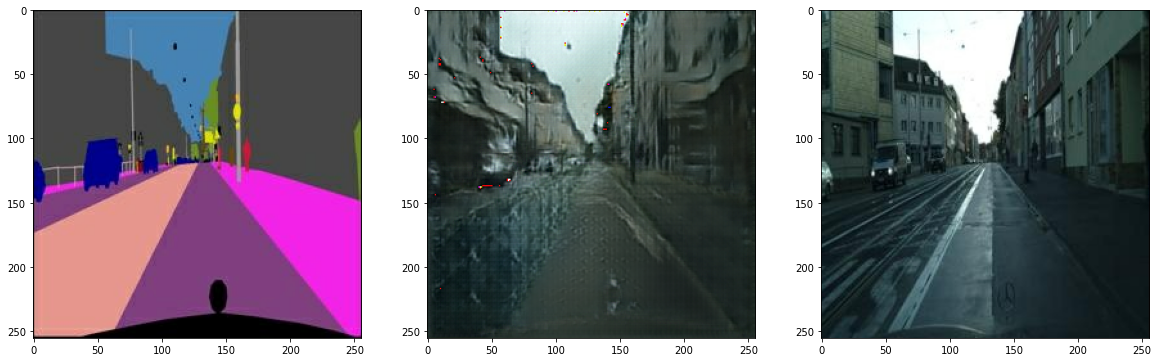

In [ ]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))